In [61]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 31 14:33:57 2023

@author: Lin
"""

import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import sys
sys.path.append(current_path+'/../../')
import myInput
import post_processing as inclination_processing
import PACKAGE_MP_3DLinear as linear3d

## Functions

In [102]:

def simple_magnitude(freqArray):
    xLim = [0, 360]
    binValue = 10.01
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)

    freqArray_circle = np.ones(binNum)
    freqArray_circle = freqArray_circle/sum(freqArray_circle*binValue)

    magnitude_max = np.max(abs(freqArray - freqArray_circle))/np.average(freqArray_circle)
    magnitude_ave = np.average(abs(freqArray - freqArray_circle))/np.average(freqArray_circle)

    magnitude_stan = np.sqrt(np.sum((abs(freqArray - freqArray_circle)/np.average(freqArray_circle) - magnitude_ave)**2)/binNum)

    return magnitude_ave, magnitude_stan

def get_poly_center(micro_matrix, step):
    # Get the center of all non-periodic grains in matrix
    num_grains = int(np.max(micro_matrix[step,:]))
    center_list = np.zeros((num_grains,2))
    sites_num_list = np.zeros(num_grains)
    ave_radius_list = np.zeros(num_grains)
    coord_refer_i = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    coord_refer_j = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    for i in range(micro_matrix.shape[1]):
        for j in range(micro_matrix.shape[2]):
            coord_refer_i[i,j] = i
            coord_refer_j[i,j] = j

    table = micro_matrix[step,:,:,0]
    for i in range(num_grains):
        sites_num_list[i] = np.sum(table == i+1)

        if (sites_num_list[i] < 500) or \
           (np.max(coord_refer_i[table == i+1]) - np.min(coord_refer_i[table == i+1]) == micro_matrix.shape[1]) or \
           (np.max(coord_refer_j[table == i+1]) - np.min(coord_refer_j[table == i+1]) == micro_matrix.shape[2]): # grains on bc are ignored
          center_list[i, 0] = 0
          center_list[i, 1] = 0
          sites_num_list[i] == 0
        else:
          center_list[i, 0] = np.sum(coord_refer_i[table == i+1]) / sites_num_list[i]
          center_list[i, 1] = np.sum(coord_refer_j[table == i+1]) / sites_num_list[i]
    ave_radius_list = np.sqrt(sites_num_list / np.pi)

    return center_list, ave_radius_list

def get_poly_statistical_radius(micro_matrix, sites_list, step):
    # Get the max offset of average radius and real radius
    center_list, ave_radius_list = get_poly_center(micro_matrix, step)
    num_grains = int(np.max(micro_matrix[step,:]))

    max_radius_offset_list = np.zeros(num_grains)
    for n in range(num_grains):
        center = center_list[n]
        ave_radius = ave_radius_list[n]
        sites = sites_list[n]

        if ave_radius != 0:
          for sitei in sites:
              [i,j] = sitei
              current_radius = np.sqrt((i - center[0])**2 + (j - center[1])**2)
              radius_offset = abs(current_radius - ave_radius)
              if radius_offset > max_radius_offset_list[n]: max_radius_offset_list[n] = radius_offset

          max_radius_offset_list[n] = max_radius_offset_list[n] / ave_radius

    max_radius_offset = np.average(max_radius_offset_list[max_radius_offset_list!=0])
    area_list = np.pi*ave_radius_list*ave_radius_list
    if np.sum(area_list) == 0: max_radius_offset = 0
    else: max_radius_offset = np.sum(max_radius_offset_list * area_list) / np.sum(area_list)

    return max_radius_offset

def get_poly_statistical_ar(micro_matrix, step):
    # Get the average aspect ratio
    num_grains = int(np.max(micro_matrix[step,:]))
    sites_num_list = np.zeros(num_grains)
    coord_refer_i = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    coord_refer_j = np.zeros((micro_matrix.shape[1], micro_matrix.shape[2]))
    for i in range(micro_matrix.shape[1]):
        for j in range(micro_matrix.shape[2]):
            coord_refer_i[i,j] = i
            coord_refer_j[i,j] = j

    aspect_ratio_i = np.zeros((num_grains,2))
    aspect_ratio_j = np.zeros((num_grains,2))
    aspect_ratio = np.zeros(num_grains)
    table = micro_matrix[step,:,:,0]

    aspect_ratio_i_list = [[] for _ in range(int(num_grains))]
    aspect_ratio_j_list = [[] for _ in range(int(num_grains))]
    for i in range(micro_matrix.shape[1]):
        for j in range(micro_matrix.shape[2]):
            grain_id = int(table[i][j]-1)
            sites_num_list[grain_id] +=1
            aspect_ratio_i_list[grain_id].append(coord_refer_i[i][j])
            aspect_ratio_j_list[grain_id].append(coord_refer_j[i][j])

    for i in range(num_grains):
        aspect_ratio_i[i, 0] = len(list(set(aspect_ratio_i_list[i])))
        aspect_ratio_j[i, 1] = len(list(set(aspect_ratio_j_list[i])))
        if aspect_ratio_j[i, 1] == 0: aspect_ratio[i] = 0
        else: aspect_ratio[i] = aspect_ratio_i[i, 0] / aspect_ratio_j[i, 1]

    aspect_ratio = np.sum(aspect_ratio * sites_num_list) / np.sum(sites_num_list)

    return aspect_ratio

def euler2quaternion(yaw, pitch, roll):
    """Convert euler angle into quaternion"""

    qx = np.cos(pitch/2.)*np.cos((yaw+roll)/2.)
    qy = np.sin(pitch/2.)*np.cos((yaw-roll)/2.)
    qz = np.sin(pitch/2.)*np.sin((yaw-roll)/2.)
    qw = np.cos(pitch/2.)*np.sin((yaw+roll)/2.)

    return [qx, qy, qz, qw]


def symquat(index, Osym = 24):
    """Convert one(index) symmetric matrix into a quaternion """

    q = np.zeros(4)

    if Osym == 24:
        SYM = np.array([[1, 0, 0,  0, 1, 0,  0, 0, 1],
                        [1, 0, 0,  0, -1, 0,  0, 0, -1],
                        [1, 0, 0,  0, 0, -1,  0, 1, 0],
                        [1, 0, 0,  0, 0, 1,  0, -1, 0],
                        [-1, 0, 0,  0, 1, 0,  0, 0, -1],
                        [-1, 0, 0,  0, -1, 0,  0, 0, 1],
                        [-1, 0, 0,  0, 0, -1,  0, -1, 0],
                        [-1, 0, 0,  0, 0, 1,  0, 1, 0],
                        [0, 1, 0, -1, 0, 0,  0, 0, 1],
                        [0, 1, 0,  0, 0, -1, -1, 0, 0],
                        [0, 1, 0,  1, 0, 0,  0, 0, -1],
                        [0, 1, 0,  0, 0, 1,  1, 0, 0],
                        [0, -1, 0,  1, 0, 0,  0, 0, 1],
                        [0, -1, 0,  0, 0, -1,  1, 0, 0],
                        [0, -1, 0, -1, 0, 0,  0, 0, -1],
                        [0, -1, 0,  0, 0, 1, -1, 0, 0],
                        [0, 0, 1,  0, 1, 0, -1, 0, 0],
                        [0, 0, 1,  1, 0, 0,  0, 1, 0],
                        [0, 0, 1,  0, -1, 0,  1, 0, 0],
                        [0, 0, 1, -1, 0, 0,  0, -1, 0],
                        [0, 0, -1,  0, 1, 0,  1, 0, 0],
                        [0, 0, -1, -1, 0, 0,  0, 1, 0],
                        [0, 0, -1,  0, -1, 0, -1, 0, 0],
                        [0, 0, -1,  1, 0, 0,  0, -1, 0]])
    elif Osym == 12:
        a = np.sqrt(3)/2
        SYM = np.array([[1,  0, 0,  0,   1, 0,  0, 0,  1],
                        [-0.5,  a, 0, -a, -0.5, 0,  0, 0,  1],
                        [-0.5, -a, 0,  a, -0.5, 0,  0, 0,  1],
                        [0.5,  a, 0, -a, 0.5, 0,  0, 0,  1],
                        [-1,  0, 0,  0,  -1, 0,  0, 0,  1],
                        [0.5, -a, 0,  a, 0.5, 0,  0, 0,  1],
                        [-0.5, -a, 0, -a, 0.5, 0,  0, 0, -1],
                        [1,  0, 0,  0,  -1, 0,  0, 0, -1],
                        [-0.5,  a, 0,  a, 0.5, 0,  0, 0, -1],
                        [0.5,  a, 0,  a, -0.5, 0,  0, 0, -1],
                        [-1,  0, 0,  0,   1, 0,  0, 0, -1],
                        [0.5, -a, 0, -a, -0.5, 0,  0, 0, -1]])

    if (1+SYM[index, 0]+SYM[index, 4]+SYM[index, 8]) > 0:
        q4 = np.sqrt(1+SYM[index, 0]+SYM[index, 4]+SYM[index, 8])/2
        q[0] = q4
        q[1] = (SYM[index, 7]-SYM[index, 5])/(4*q4)
        q[2] = (SYM[index, 2]-SYM[index, 6])/(4*q4)
        q[3] = (SYM[index, 3]-SYM[index, 1])/(4*q4)
    elif (1+SYM[index, 0]-SYM[index, 4]-SYM[index, 8]) > 0:
        q4 = np.sqrt(1+SYM[index, 0]-SYM[index, 4]-SYM[index, 8])/2
        q[0] = (SYM[index, 7]-SYM[index, 5])/(4*q4)
        q[1] = q4
        q[2] = (SYM[index, 3]+SYM[index, 1])/(4*q4)
        q[3] = (SYM[index, 2]+SYM[index, 6])/(4*q4)
    elif (1-SYM[index, 0]+SYM[index, 4]-SYM[index, 8]) > 0:
        q4 = np.sqrt(1-SYM[index, 0]+SYM[index, 4]-SYM[index, 8])/2
        q[0] = (SYM[index, 2]-SYM[index, 6])/(4*q4)
        q[1] = (SYM[index, 3]+SYM[index, 1])/(4*q4)
        q[2] = q4
        q[3] = (SYM[index, 7]+SYM[index, 5])/(4*q4)
    elif (1-SYM[index, 0]-SYM[index, 4]+SYM[index, 8]) > 0:
        q4 = np.sqrt(1-SYM[index, 0]-SYM[index, 4]+SYM[index, 8])/2
        q[0] = (SYM[index, 3]-SYM[index, 1])/(4*q4)
        q[1] = (SYM[index, 2]+SYM[index, 6])/(4*q4)
        q[2] = (SYM[index, 7]+SYM[index, 5])/(4*q4)
        q[3] = q4

    return q


def quat_Multi(q1, q2):
    """Return the product of two quaternion"""

    q = np.zeros(4)
    q[0] = q1[0]*q2[0] - q1[1]*q2[1] - q1[2]*q2[2] - q1[3]*q2[3]
    q[1] = q1[0]*q2[1] + q1[1]*q2[0] + q1[2]*q2[3] - q1[3]*q2[2]
    q[2] = q1[0]*q2[2] - q1[1]*q2[3] + q1[2]*q2[0] + q1[3]*q2[1]
    q[3] = q1[0]*q2[3] + q1[1]*q2[2] - q1[2]*q2[1] + q1[3]*q2[0]

    return q


def quaternions(q1, q2, symm2quat_matrix, Osym=24):
    """Return the misorientation of two quaternion"""

    q = np.zeros(4)
    misom = 2*np.pi
    # print(f"q1: {q1}, q2: {q2}")
    for i in range(0, Osym):
        for j in range(0, Osym):
            q1b = quat_Multi(symm2quat_matrix[i], q1)
            q2b = quat_Multi(symm2quat_matrix[j], q2)

            q2b[1] = -q2b[1]
            q2b[2] = -q2b[2]
            q2b[3] = -q2b[3]

            q = quat_Multi(q1b, q2b)
            # print(q)
            miso0 = 2*math.acos(round(q[0], 5))

            if miso0 > np.pi:
                miso0 = miso0 - 2*np.pi
            if abs(miso0) < misom:
                misom = abs(miso0)
                qmin = q.copy()

    miso0 = 2*math.acos(round(qmin[0], 5))
    if miso0 > np.pi:
        miso0 = miso0 - 2*np.pi

    if math.sin(miso0/2):
        axis = qmin[1:]/math.sin(miso0/2)
    else:
        axis = np.array([0, 0, 1])

    return abs(miso0), axis


def multiP_calM(i, quartAngle, symm2quat_matrix, Osym):
    """output the value of MisoEnergy by inout the two grain ID: i[0] and i[1]"""

    qi = quartAngle[i[0]-1, :]
    qj = quartAngle[i[1]-1, :]

    theta, axis = quaternions(qi, qj, symm2quat_matrix, Osym)
    # theta = theta*(theta<1)+(theta>1)
    # gamma = theta*(1-np.log(theta))
    gamma = theta
    return np.insert(axis, 0, gamma)

def pre_operation_misorientation(grainNum, init_filename, Osym=24):
    # create the marix to store euler angle and misorientation
    quartAngle = np.ones((grainNum, 4))*-2

    # Create a quaternion matrix to show symmetry
    symm2quat_matrix = np.zeros((Osym, 4))
    for i in range(0, Osym):
        symm2quat_matrix[i, :] = symquat(i, Osym)

    # read the input euler angle from *.init
    with open(init_filename, 'r', encoding='utf-8') as f:
        for line in f:
            eachline = line.split()

            if len(eachline) == 5 and eachline[0] != '#':
                lineN = int(eachline[1])-1
                if quartAngle[lineN, 0] == -2:
                    quartAngle[lineN, :] = euler2quaternion(float(eachline[2]), float(eachline[3]), float(eachline[4]))

    return symm2quat_matrix, quartAngle

def get_line(i, j):
    """Get the row order of grain i and grain j in MisoEnergy.txt (i < j)"""
    if i < j: return int(i+(j-1)*(j)/2)
    else: return int(j+(i-1)*(i)/2)

def get_misorientation_distribution_1D(microstructure, quartAngle, symm2quat_matrix, Osym, num_bin, miso_dict):
    misorientation_angle_distribution = np.zeros(num_bin)
    nx,ny,nz = microstructure.shape
    for i in tqdm(range(nx)):
        for j in range(ny):
            for k in range(nz):
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(nx,ny,nz,i,j,k)
                if ( ((microstructure[ip,j,k]-microstructure[i,j,k])!=0) or ((microstructure[im,j,k]-microstructure[i,j,k])!=0) or\
                     ((microstructure[i,jp,k]-microstructure[i,j,k])!=0) or ((microstructure[i,jm,k]-microstructure[i,j,k])!=0) or\
                     ((microstructure[i,j,kp]-microstructure[i,j,k])!=0) or ((microstructure[i,j,km]-microstructure[i,j,k])!=0) ):
                    central_site = int(microstructure[i,j,k])
                    neighboring_sites_list = np.array([microstructure[ip,j,k], microstructure[i,jp,k], microstructure[i,j,kp], microstructure[im,j,k], microstructure[i,jm,k], microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    # print(f"center: {central_site}, neighbor: {neighboring_sites_set}")
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    for m in range(len(neighboring_sites_list_unque)):
                        pair_id = get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                        # calculate or extract misorientation
                        if pair_id in miso_dict:
                            misorientation_angle = miso_dict[pair_id][0]
                        else:
                            misorientation = multiP_calM([central_site, neighboring_sites_list_unque[m]], quartAngle, symm2quat_matrix, Osym)
                            misorientation_angle = misorientation[0] # miso angle
                            miso_dict[pair_id] = misorientation

                        # Get misorientation angle distribution
                        if misorientation_angle < 0 or misorientation_angle > np.pi: print(">>> Please check the miaorientation angle calculation!") # check angle error
                        misorientation_index = int(misorientation_angle//(np.pi/num_bin)) # get angle index to check the angle distribution
                        if misorientation_index == num_bin: misorientation_angle_distribution[-1] += 1 # for angle of pi as 101 bins to assign to 100 bins
                        else: misorientation_angle_distribution[misorientation_index] += 1 # all bins
    print(f"> Misorientation dictionary (len:{len(miso_dict)}) and misorientation angle distribution done")

    return misorientation_angle_distribution

def get_misorientation_distribution_3D(microstructure, quartAngle, symm2quat_matrix, Osym, num_bin, miso_dict):
    misorientation_angle_distribution = np.zeros(num_bin)
    misorientation_axis_polar_angle_dsitribution = np.zeros(num_bin)
    misorientation_axis_azimuth_angle_dsitribution = np.zeros(num_bin)
    misorientation_axis_collective = []
    nx,ny,nz = microstructure.shape
    for i in tqdm(range(nx)):
        for j in range(ny):
            for k in range(nz):
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(nx,ny,nz,i,j,k)
                if ( ((microstructure[ip,j,k]-microstructure[i,j,k])!=0) or ((microstructure[im,j,k]-microstructure[i,j,k])!=0) or\
                     ((microstructure[i,jp,k]-microstructure[i,j,k])!=0) or ((microstructure[i,jm,k]-microstructure[i,j,k])!=0) or\
                     ((microstructure[i,j,kp]-microstructure[i,j,k])!=0) or ((microstructure[i,j,km]-microstructure[i,j,k])!=0) ):
                    central_site = int(microstructure[i,j,k])
                    neighboring_sites_list = np.array([microstructure[ip,j,k], microstructure[i,jp,k], microstructure[i,j,kp], microstructure[im,j,k], microstructure[i,jm,k], microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    # print(f"center: {central_site}, neighbor: {neighboring_sites_set}")
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    for m in range(len(neighboring_sites_list_unque)):
                        pair_id = get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                        # calculate or extract misorientation
                        if pair_id in miso_dict:
                            misorientation_angle = miso_dict[pair_id][0]
                            misorientation_axis = miso_dict[pair_id][1:]
                        else:
                            misorientation = multiP_calM([central_site, neighboring_sites_list_unque[m]], quartAngle, symm2quat_matrix, Osym)
                            misorientation_angle = misorientation[0] # miso angle
                            misorientation_axis = misorientation[1:]
                            miso_dict[pair_id] = misorientation

                        # Get misorientation angle distribution
                        if misorientation_angle < 0 or misorientation_angle > np.pi: print(">>> Please check the misorientation angle calculation!") # check angle error
                        misorientation_index = int(misorientation_angle//(np.pi/num_bin)) # get angle index to check the angle distribution
                        if misorientation_index == num_bin: misorientation_angle_distribution[-1] += 1 # for angle of pi as 101 bins to assign to 100 bins
                        else: misorientation_angle_distribution[misorientation_index] += 1 # all bins
                        # Get misorientation axis collective
                        misorientation_axis_collective.append(misorientation_axis)
                        # Get polar and azimuth dsitribution
                        m_polar_angle = math.acos(misorientation_axis[2])
                        m_azimuth_angle = math.atan2(misorientation_axis[1], misorientation_axis[0]) + np.pi
                        if m_polar_angle < 0 or m_polar_angle > np.pi or m_azimuth_angle < 0 or m_azimuth_angle > 2*np.pi: print(">>> Please check the misorientation axis calculation!") # check angle error
                        m_polar_angle_index = int(m_polar_angle//(np.pi/num_bin)) # get angle index to check the angle distribution
                        m_azimuth_angle_index = int(m_azimuth_angle//(2*np.pi/num_bin)) # get angle index to check the angle distribution
                        if m_polar_angle_index == num_bin: misorientation_axis_polar_angle_dsitribution[-1] += 1 # for angle of pi as 101 bins to assign to 100 bins
                        else: misorientation_axis_polar_angle_dsitribution[m_polar_angle_index] += 1 # all bins
                        if m_azimuth_angle_index == num_bin: misorientation_axis_azimuth_angle_dsitribution[-1] += 1 # for angle of pi as 101 bins to assign to 100 bins
                        else: misorientation_axis_azimuth_angle_dsitribution[m_azimuth_angle_index] += 1 # all bins


    print(f"> Misorientation dictionary (len:{len(miso_dict)}) and misorientation angle distribution done")
    misorientation_axis_collective = np.array(misorientation_axis_collective) # a coolective iincludes all misorientation axis

    return misorientation_angle_distribution, misorientation_axis_collective, misorientation_axis_polar_angle_dsitribution, misorientation_axis_azimuth_angle_dsitribution

def calculate_expected_step(input_list, expected_grain_num=200):

    num_input = len(input_list)
    special_step_distribution = np.zeros(num_input)
    microstructure_list = []

    for input_i in range(num_input):
        npy_data = np.load(input_list[input_i])
        step_num = npy_data.shape[0]
        grain_num_list = np.zeros(step_num)
        for i in tqdm(range(step_num)):
            grain_num_list[i] = len(set(npy_data[i,:].flatten()))
        special_step_distribution[input_i] = int(np.argmin(abs(grain_num_aniso - expected_grain_num)))
        microstructure_list.append(npy_data[int(special_step_distribution[input_i]),:])
    print("> Step calculation done")

    return special_step_distribution, microstructure_list

def get_inclination_angle_distribution_1D(P, sites, miso_dict, num_bin):

    microstructure = P[0,:]
    inclination_angle_distribution = np.zeros(num_bin)
    for sitei in tqdm(sites):
        [i,j,k] = sitei
        # Get the site pair to caluclate misorientation
        nx, ny, nz = microstructure.shape
        ip,im,jp,jm,kp,km = myInput.periodic_bc3d(nx,ny,nz,i,j,k)
        central_site = int(microstructure[i,j,k])
        neighboring_sites_list = np.array([microstructure[ip,j,k], microstructure[i,jp,k], microstructure[i,j,kp], microstructure[im,j,k], microstructure[i,jm,k], microstructure[i,j,km]]).astype(int)
        neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
        if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
        neighboring_sites_list_unque = list(neighboring_sites_set)
        if len(neighboring_sites_list_unque) > 1: continue # ignore the site on TJs
        pair_id = get_line(central_site, neighboring_sites_list_unque[0]) # get pair id

        # Get misorientation axis
        # print(pair_id)
        misorientation = miso_dict[pair_id] # get the misorientation of specific site
        misorientation_axis = misorientation[1:] # get misorientation axis

        # Get inclination
        dx,dy,dz = myInput.get_grad3d(P,i,j,k)
        dy = -dy # Update the issue in VECTOR
        inclination = np.array([dx,dy,dz])

        # Make sure inclination angle is between [0, pi/2]
        inclination_cos_angle = round(np.sum(misorientation_axis*inclination), 2)
        inclination_angle = math.acos(abs(inclination_cos_angle))
        if inclination_angle > np.pi/2: inclination_angle = np.pi - inclination_angle

        inclination_index = int(inclination_angle//(np.pi/num_bin)) # get angle index to check the angle distribution
        if inclination_index == num_bin: inclination_angle_distribution[-1] += 1 # for angle of pi as 101 bins to assign to 100 bins
        else: inclination_angle_distribution[inclination_index] += 1 # all bins

    return inclination_angle_distribution

# def get_inclination_angle_distribution_2D(P, sites, miso_dict, num_bin):

#     microstructure = P[0,:]
#     inclination_angle_distribution = np.zeros(num_bin)
#     for sitei in tqdm(sites):
#         [i,j,k] = sitei
#         # Get the site pair to caluclate misorientation
#         nx, ny, nz = microstructure.shape
#         ip,im,jp,jm,kp,km = myInput.periodic_bc3d(nx,ny,nz,i,j,k)
#         central_site = int(microstructure[i,j,k])
#         neighboring_sites_list = np.array([microstructure[ip,j,k], microstructure[i,jp,k], microstructure[i,j,kp], microstructure[im,j,k], microstructure[i,jm,k], microstructure[i,j,km]]).astype(int)
#         neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
#         if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
#         neighboring_sites_list_unque = list(neighboring_sites_set)
#         if len(neighboring_sites_list_unque) > 1: continue # ignore the site on TJs
#         pair_id = get_line(central_site, neighboring_sites_list_unque[0]) # get pair id

#         # Get misorientation axis
#         # print(pair_id)
#         misorientation = miso_dict[pair_id] # get the misorientation of specific site
#         misorientation_axis = misorientation[1:] # get misorientation axis

#         # Get inclination
#         dx,dy,dz = myInput.get_grad3d(P,i,j,k)
#         dy = -dy # Update the issue in VECTOR
#         inclination = np.array([dx,dy,dz])

#         # Make sure inclination angle is between [0, pi/2]
#         inclination_cos_angle = round(np.sum(misorientation_axis*inclination), 2)
#         inclination_angle = math.acos(abs(inclination_cos_angle))
#         if inclination_angle > np.pi/2: inclination_angle = np.pi - inclination_angle

#         inclination_index = int(inclination_angle//(np.pi/num_bin)) # get angle index to check the angle distribution
#         if inclination_index == num_bin: inclination_angle_distribution[-1] += 1 # for angle of pi as 101 bins to assign to 100 bins
#         else: inclination_angle_distribution[inclination_index] += 1 # all bins

#     return inclination_angle_distribution

print("Done")

## initial

In [120]:

if __name__ == '__main__':
    # File name
    init_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/3d_poly/IC/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/3d_poly_fully/results/"
    init_file_name = "poly_IC150_1k.init"
    npy_file_name_aniso = f"p_ori_fully5d_aveE_150_1k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    npy_file_name_iso = f"p_iso_150_1k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    input_npy_data = [npy_file_folder+npy_file_name_aniso, npy_file_folder+npy_file_name_iso]
    compare_label = ["Anisotropic", "Isotropic"]

    # Get time step with expected grain num
    expected_grain_num = 50
    special_step_distribution, microstructure_list = calculate_expected_step(input_npy_data, expected_grain_num)

    # misorientation
    grain_num = 1000
    Osym = 24
    symm2quat_matrix, quartAngle = pre_operation_misorientation(grain_num, init_file_folder + init_file_name, Osym)
    num_bin = 100
    print("> Pre-work done")


100%|██████████| 76/76 [00:39<00:00,  1.92it/s]


> Step calculation done
> Pre-work done


## misorientation calculation

In [121]:
    # Get misorientation angle distribution and dictionary
    misorientation_angle_distribution_list = []
    misorientation_axis_collective_list = []
    misorientation_axis_polar_angle_distribution_list = []
    misorientation_axis_azimuth_angle_distribution_list = []
    miso_dict = dict()
    for i in range(len(input_npy_data)):
        microstructure = microstructure_list[i]
        misorientation_angle_distribution, misorientation_axis_collective, misorientation_axis_polar_angle_distribution, misorientation_axis_azimuth_angle_distribution = get_misorientation_distribution_3D(microstructure, quartAngle, symm2quat_matrix, Osym, num_bin, miso_dict)
        misorientation_angle_distribution_list.append(misorientation_angle_distribution)
        misorientation_axis_collective_list.append(misorientation_axis_collective)
        misorientation_axis_polar_angle_distribution_list.append(misorientation_axis_polar_angle_distribution)
        misorientation_axis_azimuth_angle_distribution_list.append(misorientation_axis_azimuth_angle_distribution)
        print(f"> {compare_label[i]} done")

100%|██████████| 150/150 [00:29<00:00,  5.06it/s]


> Misorientation dictionary (len:351) and misorientation angle distribution done
> Anisotropic done


100%|██████████| 150/150 [00:47<00:00,  3.17it/s]

> Misorientation dictionary (len:1622) and misorientation angle distribution done
> Isotropic done


## plot

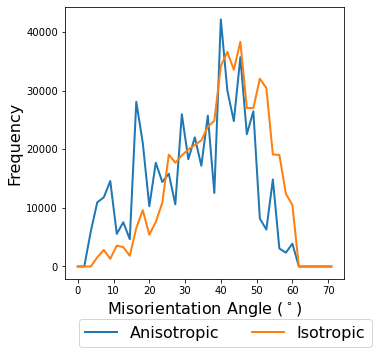

In [122]:
    # plot misorientation angle distribution
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    num_bin_plot = int(0.4*num_bin)
    for i in range(len(input_npy_data)):
        plt.plot(np.linspace(0,180,num_bin)[:num_bin_plot], misorientation_angle_distribution_list[i][:num_bin_plot], label=compare_label[i], linewidth=2)
    plt.legend(loc=(0.05,-0.25),fontsize=16, ncol=2)
    plt.xlabel(r"Misorientation Angle ($^\circ$)", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.savefig(current_path + f"/figures/misorientation_angle_distribution_3d_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')

    # plot misorientation axis distribution
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    num_bin_plot = int(0.4*num_bin)
    for i in range(len(input_npy_data)):
        plt.plot(np.linspace(0,180,num_bin)[:num_bin_plot], misorientation_axis_polar_angle_distribution_list[i][:num_bin_plot], label=compare_label[i], linewidth=2)
    plt.legend(loc=(0.05,-0.25),fontsize=16, ncol=2)
    plt.xlabel(r"Misorientation Axis Polar Angle ($^\circ$)", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.savefig(current_path + f"/figures/misorientation_axis_polar_distribution_3d_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')

    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    num_bin_plot = int(0.4*num_bin)
    for i in range(len(input_npy_data)):
        plt.plot(np.linspace(0,180,num_bin)[:num_bin_plot], misorientation_axis_azimuth_angle_distribution_list[i][:num_bin_plot], label=compare_label[i], linewidth=2)
    plt.legend(loc=(0.05,-0.25),fontsize=16, ncol=2)
    plt.xlabel(r"Misorientation Axis Azimuth Angle ($^\circ$)", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.savefig(current_path + f"/figures/misorientation_axis_azimuth_distribution_3d_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')

## Inclination calculation !! Unfinished

In [123]:
    inclination_angle_distribution_list = []
    num_bin_inclination = 50
    num_bin_inclination_plot = int(70/90*num_bin_inclination)
    for i in range(len(input_npy_data)):
        microstructure = microstructure_list[i]
        # Aniso - ave
        data_file_name = f'/3D_normal_distribution_data/3D_normal_distribution_ave_fully_{compare_label[i]}_step{special_step_distribution[i]}.npz'
        if os.path.exists(current_path + data_file_name):
            inclination_npz_data = np.load(current_path + data_file_name)
            P = inclination_npz_data["P"]
            sites = inclination_npz_data["sites"]
        else:
            newplace = np.rot90(microstructure, 1, (0,1))
            P, sites = inclination_processing.get_normal_vector_3d(newplace)
            np.savez(current_path + data_file_name, P=P, sites=sites)

        inclination_angle_distribution = get_inclination_angle_distribution_1D(P, sites, miso_dict, num_bin_inclination)
        inclination_angle_distribution_list.append(inclination_angle_distribution)
        print(f"> {compare_label[i]} done")



my core time is 453.089902
res_back start...
my res time is 0.043316
my core time is 461.016507
my core time is 462.818416
res_back start...
my res time is 0.019392
res_back start...
my res time is 0.016536
my core time is 464.45762
res_back start...
my res time is 0.016293
my core time is 472.050405
res_back start...
my res time is 0.017344
my core time is 488.457435
res_back start...
my res time is 0.016422
my core time is 503.440724
res_back start...
my res time is 0.018551
my core time is 514.272432
res_back start...
my res time is 0.016566
core done!
Total num of GB sites: 490962


100%|██████████| 490962/490962 [00:15<00:00, 31669.38it/s]

> Anisotropic done



my core time is 458.388139
res_back start...
my res time is 0.044939
my core time is 457.940969
res_back start...
my res time is 0.016473
my core time is 468.483775
res_back start...
my res time is 0.016494
my core time is 468.244282
res_back start...
my res time is 0.016201
my core time is 471.103355
res_back start...
my res time is 0.017252
my core time is 472.367747
res_back start...
my res time is 0.016326
my core time is 487.555821
res_back start...
my res time is 0.01612
my core time is 490.665029
res_back start...
my res time is 0.01678
core done!
Total num of GB sites: 498277


100%|██████████| 498277/498277 [00:15<00:00, 31627.83it/s]


> Isotropic done


## Plot

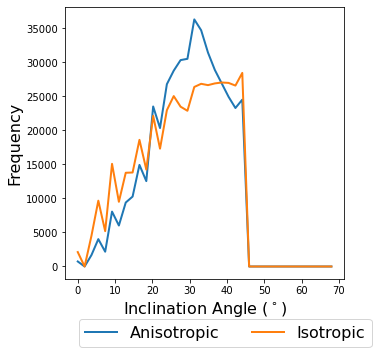

In [124]:
    # plot misorientation angle distribution
    plt.close()
    fig = plt.figure(figsize=(5, 5))
    for i in range(len(input_npy_data)):
        plt.plot(np.linspace(0,90,num_bin_inclination)[:num_bin_inclination_plot], inclination_angle_distribution_list[i][:num_bin_inclination_plot], label=compare_label[i], linewidth=2)
    plt.legend(loc=(0.05,-0.25),fontsize=16, ncol=2)
    plt.xlabel(r"Inclination Angle ($^\circ$)", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.savefig(current_path + f"/figures/inclination_distribution_3d_{expected_grain_num}grains.png", dpi=400,bbox_inches='tight')